# RGB-D Fusion

This exercise will describe how to fuse images from known poses into one pointcloud.
The excercise is divided into the following steps.

1. Load recorded images and poses.
2. 

Note: if the interactive viewer does not work you may have to restart the notebook with `%matplotlib widget` instead of `%matplotlib notebook`

Note: install jupyter in your conda environment via `conda install -c conda-forge notebook` and the other missing packages. Start it in the command line via` jupter notebook --port xxxx`. Use the vs-code pop up to open jupyter in your local server.

Note: we use [Open3D](http://www.open3d.org/) for this exercise. Unfortunately the visualization requires OpenGL, which fails for setups like ours, where the visualization and the code run on separate machines. A minimal working solution (with drawbacks in quality) is to start a jupyter notebook on one of the pool machines (not the login) and use vscode for port-forwarding it to your local browser.
**The recommended way is to run everything on your local machine**

In [3]:
# %matplotlib notebook
# %matplotlib widget
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
try:
    import open3d as o3d
except ImportError:
    pass

log = logging.getLogger(__name__)
np.set_printoptions(suppress=True)

In [3]:
# Download the data required for this exercise (30Mb)
! wget https://lmb.informatik.uni-freiburg.de/people/argusm/wd_40.tar
! tar -xvf wd_40.tar
# or find them here
! ls /project/cv-ws2122/shared-data1/wd_40

--2022-02-10 09:14:48--  https://lmb.informatik.uni-freiburg.de/people/argusm/wd_40.tar
Resolving lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)... 132.230.167.23
Connecting to lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58736640 (56M) [application/x-tar]
Saving to: ‘wd_40.tar’

wd_40.tar           100%[===================>]  56.02M  5.64MB/s    in 9.9s    

2022-02-10 09:14:58 (5.64 MB/s) - ‘wd_40.tar’ saved [58736640/58736640]

wd_40/depth_0001.png
wd_40/depth_0002.png
wd_40/depth_0003.png
wd_40/depth_0004.png
wd_40/depth_0005.png
wd_40/depth_0006.png
wd_40/depth_0007.png
wd_40/depth_0008.png
wd_40/depth_0009.png
wd_40/depth_0010.png
wd_40/depth_0011.png
wd_40/depth_0012.png
wd_40/depth_0013.png
wd_40/depth_0014.png
wd_40/depth_0015.png
wd_40/depth_0016.png
wd_40/depth_0017.png
wd_40/depth_0018.png
wd_40/depth_0019.png
wd_40/depth_0020.png
wd_40/depth_0021.png

# 1. Load Recorded Images

This cell defines a data class that loads images and data from files.

Please complete the `get_projection_matrix` function.

In [4]:
import json
from PIL import Image

class ViewLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        assert os.path.isdir(base_path)
        files = sorted(os.listdir(self.base_path))
        files = [f for f in files if (f.startswith("rgb_") and f.endswith(".png"))]
        self.max_idx = int(files[-1].replace("rgb_", "").replace(".png", ""))
        print(f"Loaded {self.max_idx+1} images.")
        
    def __len__(self):
        return self.max_idx + 1
    
    def __getitem__(self, idx):
        return self.get_rgbdp(idx)

    def get_info(self):
        info = {
            "camera": {"calibration": 
            {"width": 640, "height": 480,
            "fx": 617.8902587890625, "fy": 617.8903198242188,
            "ppx": 315.20367431640625, "ppy": 245.70614624023438}}
        }
        return info
    
    def get_intrinsics(self):
        info = self.get_info()
        calib = info["camera"]["calibration"]
        return calib
    
    def get_K(self):
        calib = self.get_intrinsics()
        cam_intrinsic = np.eye(3)
        cam_intrinsic[0, 0] = calib["fx"]
        cam_intrinsic[1, 1] = calib["fy"]
        cam_intrinsic[0, 2] = calib["ppx"]
        cam_intrinsic[1, 2] = calib["ppy"]
        return cam_intrinsic
    
    def get_robot_pose(self, idx, return_dict=False):
        pose_file = os.path.join(self.base_path, "pose_{0:04d}.json".format(idx) )
        with open(pose_file,"rb") as f_obj:
            pose = json.load(f_obj)
        pose_m = np.eye(4)
        pose_m[:3, :3] = R.from_euler("xyz", [pose[x] for x in ['rot_x', 'rot_y', 'rot_z']]).as_matrix()
        pose_m[:3, 3] = [pose[x] for x in ['x', 'y', 'z']]
        if return_dict:
            return pose_m, pose
        else:
            return pose_m
    
    def get_rgb_file(self, idx):
        rgb_file = os.path.join(self.base_path, "rgb_{0:04d}.png".format(idx) )
        return rgb_file
    
    def get_depth_file(self, idx):
        depth_file = os.path.join(self.base_path, "depth_{0:04d}.png".format(idx) )
        return depth_file    
    
    def get_rgbdp(self, idx):
        rgb_file = self.get_rgb_file(idx)
        depth_file = self.get_depth_file(idx)
        
        pose_m, pose_d = self.get_robot_pose(idx, True)
        # depth
        depth_scaling = pose_d["depth_scaling"]
        rgb  = np.asarray(Image.open(rgb_file))
        depth = np.asarray(Image.open(depth_file), dtype=np.float32) * depth_scaling
        return rgb, depth, pose_m
        
    def get_cam_pose(self, idx, marker_dir="pose_marker_one"):
        marker_dir = os.path.join(self.base_path, marker_dir)
        fn  = "{0:08d}.json".format(idx)
        pose_fn = os.path.join(marker_dir, fn)
        with open(pose_fn, "r") as fo:
            T = np.array(json.load(fo))
        return T
    
    def get_projection_matrix(self):
        # returns a 4x3 projection matrix using the intrinsics
        intr = self.get_intrinsics()
        cam_mat = np.array([[intr['fx'], 0, intr['ppx'], 0],
                            [0, intr['fy'], intr['ppy'], 0],
                            [0, 0, 1, 0]])
        assert cam_mat.shape == (3, 4)
        return cam_mat
    

    def project(self, X):
        """
        Project an (homogenous) cartesian coordinate into the camera frame.
        """
        if X.shape[0] == 3:
            if len(X.shape) == 1:
                X = np.append(X, 1)
            else:
                X = np.concatenate([X, np.ones((1, X.shape[1]))], axis=0)

        x = self.get_projection_matrix() @ X
        result = np.round(x[0:2] / x[2]).astype(int)
        width, height = self.get_intrinsics()['width'], self.get_intrinsics()['height']
        if not (0 <= result[0] < width and 0 <= result[1] < height):
            log.warning("Projected point outside of image bounds")
        return result[0], result[1]

# vl = ViewLoader(base_path="TODO:insert path to wd_40 here")
vl = ViewLoader(base_path="wd_40")
print("camera calibration:")
camera_calibration = vl.get_K()
K = np.array(camera_calibration)
print(K.round(2))

Loaded 51 images.
camera calibration:
[[617.89   0.   315.2 ]
 [  0.   617.89 245.71]
 [  0.     0.     1.  ]]


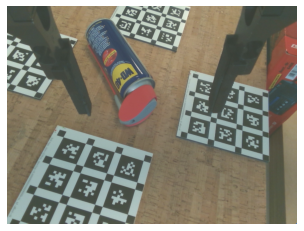

interactive(children=(IntSlider(value=2, description='w', layout=Layout(width='70%'), max=50, min=2), Output()…

<function __main__.update(w)>

In [5]:
from ipywidgets import widgets, Layout, interact

fig, ax = plt.subplots(1)
image, depth, pose = vl.get_rgbdp(2)
line = ax.imshow(np.asarray(image))
ax.set_axis_off()

def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    line.set_data(np.asarray(image))
    fig.canvas.draw_idle()
    # plt.imshow(np.asarray(image))
    # plt.show()
    
slider_w = widgets.IntSlider(min=2, max=len(vl)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)

# 2. Show Marker Detection Results.

To simplify things marker detection has already been run. Next we want to verify its results.
Do this by completing the `get_projection_matrix` function in the ViewLoader.
Then draw a coordinate frame into each image for which we have detection results.
The coordinate frame should have axis lengths of 10cm, with x=red, y=green, and z=blue.
This can be done using `PIL.ImageDraw`.

<class 'numpy.ndarray'>
(4, 4)


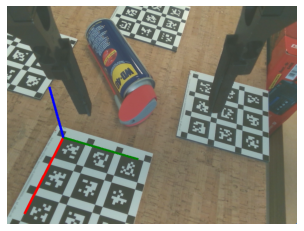

interactive(children=(IntSlider(value=2, description='w', layout=Layout(width='70%'), max=50, min=2), Output()…

<function __main__.update(w)>

In [6]:
from PIL import ImageDraw

def show_marker_pose(image, T_cam_object):
    """
    draw the coordinate frame into each image for which we have detection results
    Arguments:
        image: image as numpy.ndarray
        T_cam_object: transform from object into cam x_cam = T_cam_object @ x
    Returns:
        im: image (should be PIL.Image.Image)
    """
    print(type(image))
    print(T_cam_object.shape)
    # TODO

    #  using PIL.ImageDraw
    
    center = np.array([0, 0, 0, 1])
    x = np.array([0.1, 0, 0, 1])
    y = np.array([0, 0.1, 0, 1])
    z = np.array([0, 0, 0.1, 1])

    object_cam = T_cam_object @ center
    x_cam = T_cam_object @ x
    y_cam = T_cam_object @ y
    z_cam = T_cam_object @ z

    object_cam_p = vl.project(object_cam)
    x_cam_p = vl.project(x_cam)
    y_cam_p = vl.project(y_cam)
    z_cam_p = vl.project(z_cam)

    im = Image.fromarray(image)
    draw = ImageDraw.Draw(im)
    draw.line(object_cam_p + x_cam_p, fill="red", width=5)
    draw.line(object_cam_p + y_cam_p, fill="green", width=5)
    draw.line(object_cam_p + z_cam_p, fill="blue", width=5)

    # end TODO
    
    # type(im) should be PIL.Image.Image
    return im

image, depth, robot_pose = vl.get_rgbdp(2)
T_cam_object = vl.get_cam_pose(2)

fig, ax = plt.subplots(1)
image_m = show_marker_pose(image, T_cam_object)
line = ax.imshow(np.asarray(image_m))
ax.set_axis_off()

def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    try:
        T_cam_object = vl.get_cam_pose(w)
    except FileNotFoundError:
        print("No pose estimation.")
        line.set_data(np.asarray(image))
        return
    image_m = show_marker_pose(image, T_cam_object)
    line.set_data(np.asarray(image_m))
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=2, max=len(vl)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)

In [7]:
def get_tcp_marker_lists(m_dir="pose_marker_one"):
    T_robot_tcp_list = []
    T_cam_marker_list = []
    for i in range(len(vl)):
        try:
            robot_pose = vl.get_robot_pose(i)
            cam_pose = vl.get_cam_pose(i, marker_dir=m_dir)
        except (FileNotFoundError, ValueError):
            continue
        T_robot_tcp_list.append(robot_pose)
        T_cam_marker_list.append(cam_pose)

    return np.array(T_robot_tcp_list), np.array(T_cam_marker_list)

plot_o3d = True
# plot_o3d = False
if plot_o3d:
    T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
    mesh_frames = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
        mesh_frame.transform(np.linalg.inv(T_robot_tcp))
        mesh_frames.append(mesh_frame)
        
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.20)
        mesh_frame.transform(T_cam_marker)
        mesh_frames.append(mesh_frame)

    o3d.visualization.draw_geometries(mesh_frames)

# Display Merged Pointclouds

In [45]:
import open3d as o3d

first_rgb = Image.open(vl.get_rgb_file(2))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[1], first_rgb.size[0],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])

pcd_list = []
for i in range(2,len(vl)):
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
    except (FileNotFoundError, ValueError):
        continue
    
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(np.array(depth_file).astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
    
    #T_est = T_r @ T_calib
    T_est = np.linalg.inv(T_c)
    pcd.transform(T_est)
    pcd_list.append(pcd)

# sum pointclouds for easier visualization
pcd_all = pcd_list[0]
for pcd_cur in pcd_list[1:]:
    pcd_all += pcd_cur
o3d.visualization.draw_geometries([pcd_all])

# TODO: improve the pointcloud
- remove the gripper
- unify the points on the surface
- extract a mesh

Just try out many things. You can find some inspiration in [tutorials](http://www.open3d.org/docs/0.8.0/index.html#tutorial-index). Make sure the docs version and your installed version match, since some functionality has changed.

0.34750003


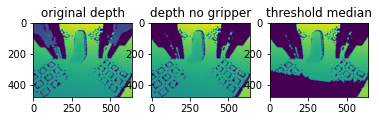

In [46]:
# use the depth values to create a mask for the gripper
image, depth, pose = vl.get_rgbdp(10)
plt.subplot(1,3,1)
plt.imshow(depth)
plt.title('original depth')

# find a depth threshold that works across images
depth_new = depth.copy()
depth_new[depth < 0.25] = 0
plt.subplot(1,3,2)
plt.title("depth no gripper")
plt.imshow(depth_new)

plt.subplot(1,3,3)
depth_median = depth.copy()
median = np.median(depth_median)
print(median)
depth_median[depth_median < median] = 0
plt.title("threshold median")
plt.imshow(depth_median)
plt.show()

In [47]:
first_rgb = Image.open(vl.get_rgb_file(2))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[0], first_rgb.size[1],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])

pcd_list = []
for i in range(2, len(vl)):
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        # get scaled depth and create a mask from it
        _, depth_, _ = vl.get_rgbdp(i)
        mask = depth_ < 0.25
        depth_file = np.array(depth_file)
        depth_file[mask] = 0
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
    except (FileNotFoundError, ValueError):
        continue
    
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(depth_file.astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
    
    #T_est = T_r @ T_calib
    T_est = np.linalg.inv(T_c)
    pcd.transform(T_est)
    pcd_list.append(pcd)

# sum pointclouds for easier visualization
pcd_all = pcd_list[0]
for pcd_cur in pcd_list[1:]:
    pcd_all += pcd_cur
o3d.visualization.draw_geometries([pcd_all])

In [48]:
# remove outliers
# Note: tested for open3d.__version__ == 0.8.0
#       open3d refactored this syntax between different versions
#       make sure to select the correct version in the docs
#       http://www.open3d.org/docs/0.8.0/
def display_inlier_outlier(cloud, ind):
    # v0.8
    # inlier_cloud = cloud.select_down_sample(ind)
    # outlier_cloud = cloud.select_down_sample(ind, invert=True)
    # v0.12
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


print("Downsample the point cloud with a voxel of 0.02")
voxel_down_pcd = pcd_all.voxel_down_sample(voxel_size = 0.002)
o3d.visualization.draw_geometries([voxel_down_pcd], window_name='Voxel downsample')

print("Every 5th points are selected")
uni_down_pcd = pcd_all.uniform_down_sample(every_k_points = 5)
o3d.visualization.draw_geometries([uni_down_pcd], window_name='Uniform point downsample')

print("Statistical oulier removal")
cl,ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.1)
o3d.visualization.draw_geometries([cl], window_name='Remove_statistical_outlier')
display_inlier_outlier(voxel_down_pcd, ind)

# This runs for a very long time
# print("Radius oulier removal")
# cl,ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.1)
# o3d.visualization.draw_geometries([cl], window_name='Remove_statistical_outlier')
# display_inlier_outlier(voxel_down_pcd, ind)

Downsample the point cloud with a voxel of 0.02
Every 5th points are selected
Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [50]:
print(pcd_all.get_min_bound())
print(pcd_all.get_max_bound())
# create a mesh
# - o3d v0.8
# volume = o3d.integration.ScalableTSDFVolume(
#     voxel_length=1.0 / 512.0,
#     sdf_trunc=0.10,
#     color_type=o3d.integration.TSDFVolumeColorType.RGB8)
# - o3d v0.12
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=1.0 / 512.0,
    sdf_trunc=0.10,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

first_rgb = Image.open(vl.get_rgb_file(2))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[0], first_rgb.size[1],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])
for i in range(2, len(vl)):
    print("Integrate {:d}-th image into the volume.".format(i))
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = np.array(Image.open(vl.get_depth_file(i)))
        # get scaled depth and create a mask from it
        _, depth_, _ = vl.get_rgbdp(i)
        mask = depth_ < 0.25
        depth_file[mask] = 0
        T_c = vl.get_cam_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
    except (FileNotFoundError, ValueError):
        continue
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(depth_file.astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    volume.integrate(
        rgbd, 
        K_o3d,
        T_c
    )

print("Extract a triangle mesh from the volume and visualize it.")
print(volume.extract_voxel_point_cloud())

mesh = volume.extract_triangle_mesh()
pcd_volume = volume.extract_point_cloud()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([pcd_volume])
o3d.visualization.draw_geometries([mesh])

[-0.55857027 -0.3139832  -0.24581634]
[0.19466689 0.54391116 0.14298662]
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.
Integrate 5-th image into the volume.
Integrate 6-th image into the volume.
Integrate 7-th image into the volume.
Integrate 8-th image into the volume.
Integrate 9-th image into the volume.
Integrate 10-th image into the volume.
Integrate 11-th image into the volume.
Integrate 12-th image into the volume.
Integrate 13-th image into the volume.
Integrate 14-th image into the volume.
Integrate 15-th image into the volume.
Integrate 16-th image into the volume.
Integrate 17-th image into the volume.
Integrate 18-th image into the volume.
Integrate 19-th image into the volume.
Integrate 20-th image into the volume.
Integrate 21-th image into the volume.
Integrate 22-th image into the volume.
Integrate 23-th image into the volume.
Integrate 24-th image into the volume.
Integrate 25-th image into the volume.

In [52]:
# crop the mesh
print(mesh.get_min_bound())
print(mesh.get_max_bound())
angle = 40/180. * np.pi
box_h, box_w, box_z = (0.1, 0.2, 0.07)
obb = o3d.geometry.OrientedBoundingBox(
    np.array([-0.125,0.035,0.03]), # center
    np.array([[np.cos(angle),-np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]]), # rotations
    np.array([box_w,box_h,box_z]) # extend
)
o3d.visualization.draw_geometries([mesh, obb])
cropped_mesh = mesh.crop(obb)
o3d.visualization.draw_geometries([cropped_mesh])


[-0.55371094 -0.29003906 -0.2451259 ]
[0.17768009 0.54003906 0.07542675]
